In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-04 08:40:32--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-06-04 08:40:32 (8.64 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



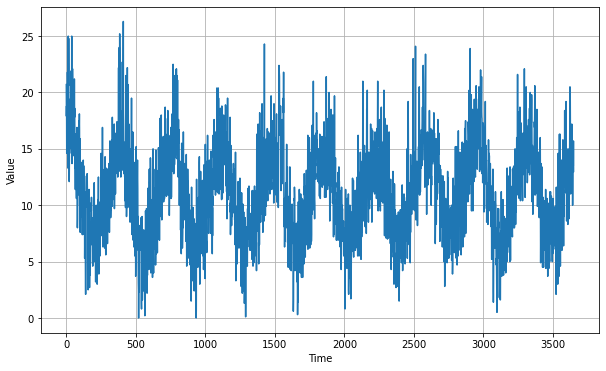

In [25]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  csv_iter = csv.reader(csvfile)
  next(csv_iter)
  for i, (_, temp) in enumerate(csv_iter):
    time_step.append(i)
    temps.append(float(temp))
  
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [26]:
split_time = 2500
time_train = time[:split_time]
x_train = temps[:split_time]
time_valid = time[split_time:]
x_valid = temps[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda x: (x[:-1], x[1:]))
    return dataset.batch(batch_size).prefetch(1)

In [36]:

def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    forecast = model.predict(dataset.batch(batch_size=32).prefetch(1))
    return forecast


In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
x_train = np.array(x_train)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: x / 30),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 30)]
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


10/10 [==============================] - 3s 26ms/step - loss: 10.2242 - mae: 10.7231
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 10.2227 - mae: 10.7216
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 10.2204 - mae: 10.7193
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 10.2176 - mae: 10.7165
Epoch 5/100
10/10 [==============================] - 0s 25ms/step - loss: 10.2144 - mae: 10.7133
Epoch 6/100
10/10 [==============================] - 0s 25ms/step - loss: 10.2107 - mae: 10.7096
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 10.2066 - mae: 10.7055
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 10.2020 - mae: 10.7009
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 10.1969 - mae: 10.6957
Epoch 10/100
10/10 [==============================] - 0s 26ms/step - loss: 10.1911 - mae: 10.6899
Epoch 11/100
10/10 [=====================

(1e-08, 0.0001, 0.0, 60.0)

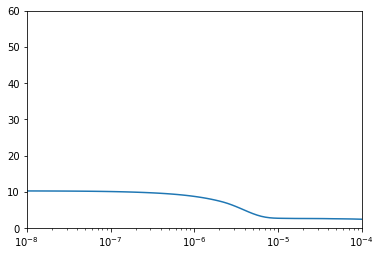

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500)]
)


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 10.6306 - mae: 11.1188
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 2.6889 - mae: 3.1547
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 2.1252 - mae: 2.5826
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 2.0286 - mae: 2.4841
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 1.9338 - mae: 2.3871
Epoch 6/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8737 - mae: 2.3262
Epoch 7/150
25/25 [==============================] - 0s 15ms/step - loss: 1.8210 - mae: 2.2724
Epoch 8/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7683 - mae: 2.2186
Epoch 9/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7554 - mae: 2.2060
Epoch 10/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7099 - mae: 2.1596
Epoch 11/150
25/25 [===========================

In [44]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

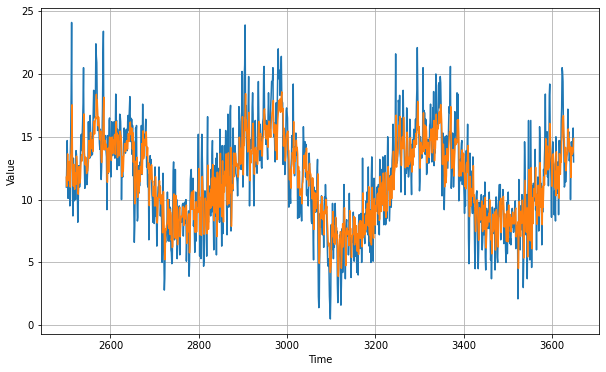

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7977656

In [47]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.779986 11.051141 12.420066 ... 13.704454 13.800256 14.857238]
